**STEP 1** NAČTENÍ AUDIO DAT A LABELS

In [149]:
import wfdb
import numpy as np
import os

def load_audio_data(directory):
    audio_data = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.dat'):
            # Load signál
            record = wfdb.rdrecord(os.path.join(directory, filename[:-4]))  # Rm .dat pro record name
            audio_data.append(record.p_signal.flatten())
            
            # Načtení labels
            label = load_label(os.path.join(directory, filename[:-4]))
            labels.append(label)
    
    return audio_data, labels

def load_label(base_filename):
    # Načtení labels
    with open(base_filename + '.txt', 'r') as f:
        label = f.readline().strip()
    return label


audio_data, labels = load_audio_data('database/')

**STEP 2** Použijeme knihovnu librosa pro extrahování pitch informací z audio signálů.

In [150]:
import librosa

def extract_pitch(audio_data):
    pitches = []
    
    for signal in audio_data:

        pitch, _ = librosa.piptrack(y=signal, sr=8000)  # Sampling rate
        # Max pitch pro každý frame
        pitch_max = np.max(pitch, axis=0)
        pitches.append(pitch_max[pitch_max > 0])  # Pouze pozitivní pitch values
    
    return pitches

# Extract pitch information
pitches = extract_pitch(audio_data)

**STEP 3** Výpočet vriability výšky tónu -> Můžeme vypočítat směrodatnou odchylku hodnot výšky tónu pro posouzení nestability výšky tónu.

In [151]:
def calculate_pitch_variability(pitches):
    variability = []
    
    for pitch in pitches:
        if len(pitch) > 0:
            std_dev = np.std(pitch)  # Standardní deviace výšek tonu
            variability.append(std_dev)
        else:
            variability.append(0)  # 0 pitch
    
    return variability

# Calculate pitch variability
pitch_variability = calculate_pitch_variability(pitches)

**STEP 4** Klasifikace nahrávek -> Nahrávky můžeme klasifikovat na základě vypočtené variability výšky tónu. Pokud variabilita překročí určitou hranici, klasifikujeme ji jako „patologickou“.


In [155]:
def classify_audio_by_pitch_variability(variability, threshold):
    classifications = []
    
    for var in variability:
        if var > threshold:
            classifications.append('Pathological')
        else:
            classifications.append('Good')
    
    return classifications

# Threshold pro pitch variability
threshold = 204  # Threshold který se ukázal jako nejvíce přesný
classifications = classify_audio_by_pitch_variability(pitch_variability, threshold)

**STEP 5** Vizualizace výsledků klasifikace a variability výšky tónu.

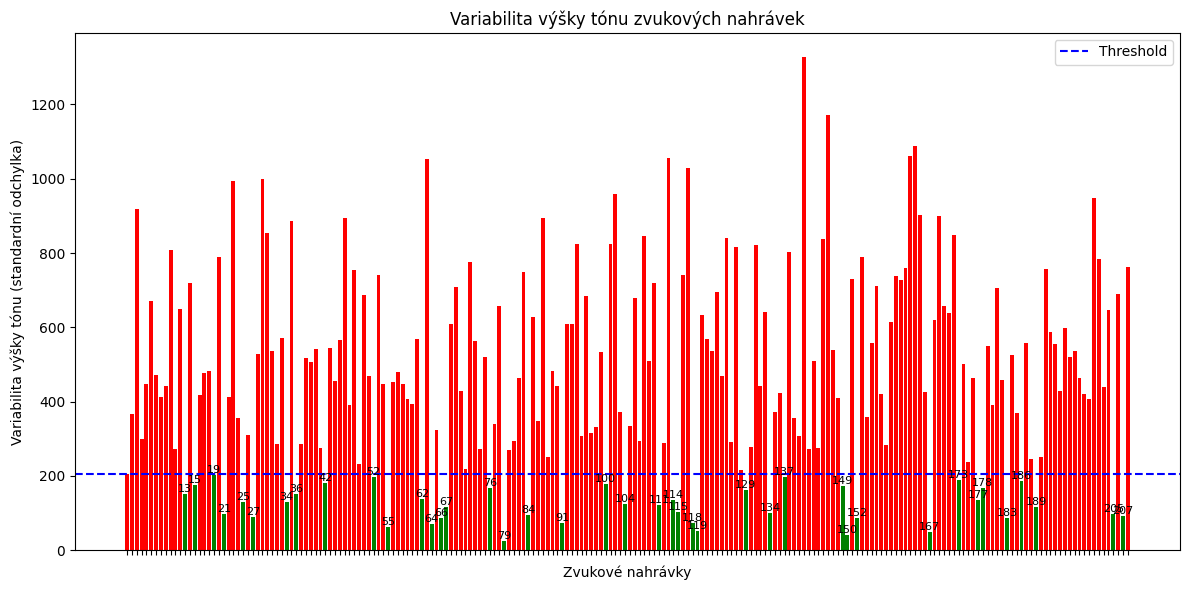

In [156]:
import matplotlib.pyplot as plt

def visualize_pitch_variability(variability, classifications):
    plt.figure(figsize=(12, 6))
    

    bars = plt.bar(range(len(variability)), variability, color=['green' if c == 'Good' else 'red' for c in classifications])
    

    plt.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
    

    plt.title('Variabilita výšky tónu zvukových nahrávek')
    plt.xlabel('Zvukové nahrávky')
    plt.ylabel('Variabilita výšky tónu (standardní odchylka)')
    

    plt.xticks(range(len(variability)), [''] * len(variability))
    

    for i, bar in enumerate(bars):
        if classifications[i] == 'Good':
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(i + 1), 
                     ha='center', va='bottom', fontsize=8)
    

    plt.legend()
    

    plt.tight_layout()
    plt.show()


visualize_pitch_variability(pitch_variability, classifications)

**STEP 6** Vizualizace zdravého a patogeního audio záznamu

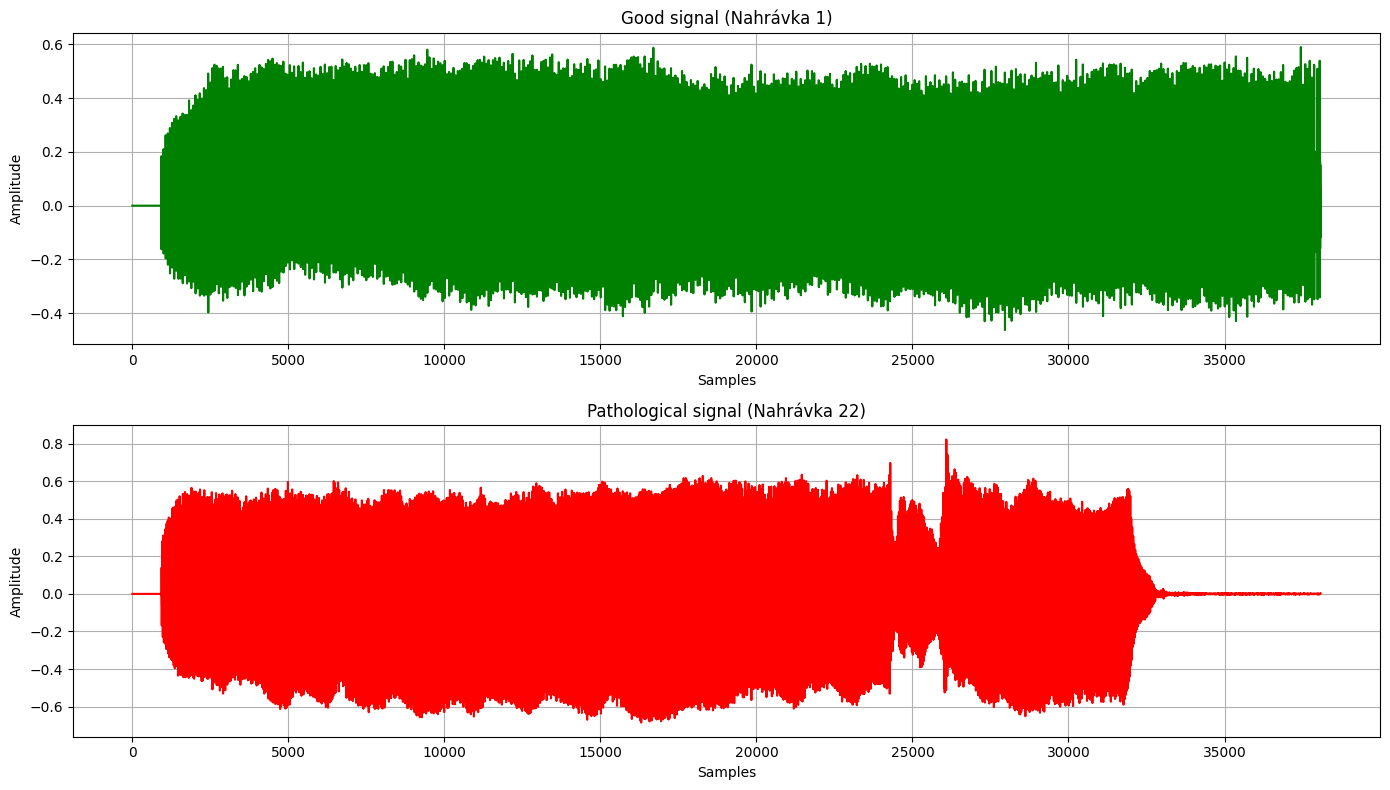

In [157]:
import matplotlib.pyplot as plt

def visualize_signals(audio_data, classifications, pitch_variability, good_index, bad_index):
    good_signal = audio_data[good_index]
    bad_signal = audio_data[bad_index]
    
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(good_signal, color='green')
    plt.title(f'Good signal (Nahrávka {good_index + 1})')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.plot(bad_signal, color='red')
    plt.title(f'Pathological signal (Nahrávka {bad_index + 1})')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid()
    
    plt.tight_layout()
    plt.show()

good_index = 0
bad_index = 21

visualize_signals(audio_data, classifications, pitch_variability, good_index, bad_index)

**STEP 7** Předběžný výsledek

In [158]:
import pandas as pd

results_df = pd.DataFrame({'Actual': labels, 'Classified': classifications})
summary = results_df.groupby(['Actual', 'Classified']).size().unstack(fill_value=0)

print(summary)

Classified  Good  Pathological
Actual                        
0.000000      41           167


**STEP 8** Spektrální analýza

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def compute_fourier_analysis(signal, sampling_rate=8000):
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1 / sampling_rate)
    psd = np.abs(fft_result) ** 2 / len(signal)
    positive_freqs = fft_freq[fft_freq >= 0]
    positive_psd = psd[fft_freq >= 0]
    return positive_freqs, positive_psd

In [144]:
def highlight_dominant_frequencies(freqs, psd, ax, color, label):
    peaks, _ = find_peaks(psd, height=np.max(psd) * 0.1, distance=20)
    ax.plot(freqs[peaks], 10 * np.log10(psd[peaks]), 'o', color=color, label=label)
    return peaks

def plot_harmonics(fundamental_freq, freqs, ax, color):
    for harmonic in range(1, 10):
        harmonic_freq = harmonic * fundamental_freq
        if harmonic_freq < max(freqs):
            ax.axvline(harmonic_freq, color=color, linestyle='--', alpha=0.5, label=f'Harmonic {harmonic}')

def compute_hnr(freqs, psd, harmonic_freqs):
    harmonic_band_energy = 0
    for f in harmonic_freqs:
        harmonic_band_energy += np.sum(psd[(freqs > f - 50) & (freqs < f + 50)])
    noise_band = psd[(freqs < min(harmonic_freqs) - 50) | (freqs > max(harmonic_freqs) + 50)]
    noise_band_energy = np.sum(noise_band)
    if noise_band_energy == 0:
        return float('inf')
    return harmonic_band_energy / noise_band_energy

def visualize_frequency_spectrum(audio_data, classifications, good_index, bad_index, sampling_rate=8000):
    good_signal = audio_data[good_index]
    bad_signal = audio_data[bad_index]
    
    good_freqs, good_psd = compute_fourier_analysis(good_signal, sampling_rate)
    bad_freqs, bad_psd = compute_fourier_analysis(bad_signal, sampling_rate)
    
    good_fundamental = good_freqs[np.argmax(good_psd)]
    bad_fundamental = bad_freqs[np.argmax(bad_psd)]
    
    plt.figure(figsize=(12, 8))
    
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(good_freqs, 10 * np.log10(good_psd), color='green', label='Zdravý Signál')
    highlight_dominant_frequencies(good_freqs, good_psd, ax1, 'blue', 'Good Peaks')
    plot_harmonics(good_fundamental, good_freqs, ax1, 'blue')
    plt.title(f'Frekvenční spektrum zdravé nahrávky (Nahrávka {good_index + 1})', fontsize=14)
    plt.xlabel('Frekvence (Hz)', fontsize=12)
    plt.ylabel('Power/Frequency (dB/Hz)', fontsize=12)
    plt.grid()
    plt.legend(fontsize=10)
    
    ax2 = plt.subplot(2, 1, 2)
    plt.plot(bad_freqs, 10 * np.log10(bad_psd), color='red', label='Pathological Signál')
    highlight_dominant_frequencies(bad_freqs, bad_psd, ax2, 'orange', 'Pathological Peaks')
    plot_harmonics(bad_fundamental, bad_freqs, ax2, 'orange')
    plt.title(f'Frekvenční spektrum patogenni nahrávky (Nahrávka {bad_index + 1})', fontsize=14)
    plt.xlabel('Frekvence (Hz)', fontsize=12)
    plt.ylabel('Power/Frequency (dB/Hz)', fontsize=12)
    plt.grid()
    plt.legend(fontsize=10)
    
    # Výpočet a zobrazení HNR
    good_hnr = compute_hnr(good_freqs, good_psd, [good_fundamental * i for i in range(1, 10)])
    bad_hnr = compute_hnr(bad_freqs, bad_psd, [bad_fundamental * i for i in range(1, 10)])
    ax1.text(0.95, 0.85, f'HNR (Good): {good_hnr:.2f}', ha='right', transform=ax1.transAxes, color='black', fontsize=12)
    ax2.text(0.95, 0.85, f'HNR (Bad): {bad_hnr:.2f}', ha='right', transform=ax2.transAxes, color='black', fontsize=12)
    
    plt.tight_layout(pad=1.0, h_pad=0.5)
    
    plt.show()


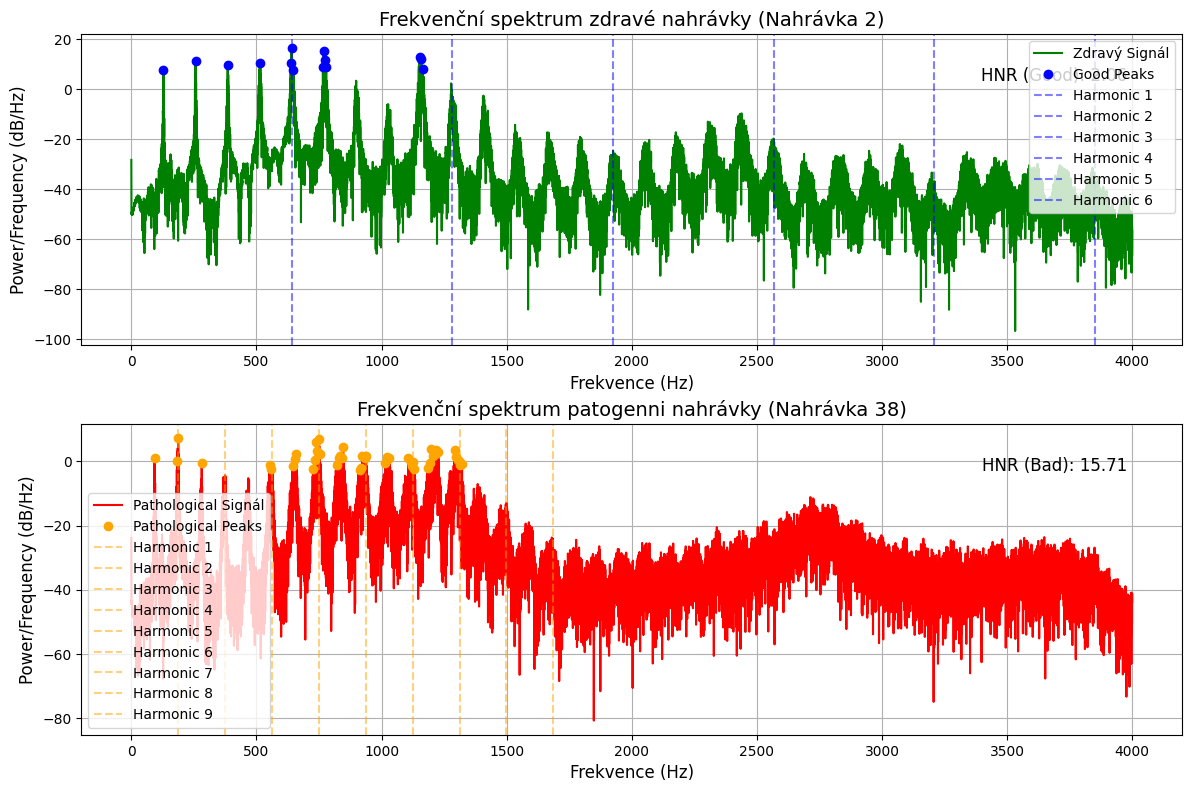

In [145]:

good_index = 1  # 0
bad_index = 37   # 21

visualize_frequency_spectrum(audio_data, classifications, good_index, bad_index)

**STEP 9** HNR VŠECH ZÁZNAMŮ

Signál 1: HNR = 0.69
Signál 2: HNR = 2.06
Signál 3: HNR = 2.38
Signál 4: HNR = 39.39
Signál 5: HNR = 2.19
Signál 6: HNR = 2.43
Signál 7: HNR = 7.77
Signál 8: HNR = 1.78
Signál 9: HNR = 67.32
Signál 10: HNR = 81.88
Signál 11: HNR = 1.16
Signál 12: HNR = 7.05
Signál 13: HNR = 2.09
Signál 14: HNR = 1.97
Signál 15: HNR = 1.36
Signál 16: HNR = 146.73
Signál 17: HNR = 0.39
Signál 18: HNR = 15.25
Signál 19: HNR = 191.33
Signál 20: HNR = 0.67
Signál 21: HNR = 251.01
Signál 22: HNR = 577.80
Signál 23: HNR = 2.78
Signál 24: HNR = 163.46
Signál 25: HNR = 2.31
Signál 26: HNR = 21.92
Signál 27: HNR = 0.86
Signál 28: HNR = 67.34
Signál 29: HNR = 6.90
Signál 30: HNR = 27.35
Signál 31: HNR = 3.75
Signál 32: HNR = 0.78
Signál 33: HNR = 1.22
Signál 34: HNR = 108.01
Signál 35: HNR = 4.05
Signál 36: HNR = 67.52
Signál 37: HNR = 12.28
Signál 38: HNR = 15.71
Signál 39: HNR = 1.21
Signál 40: HNR = 41.81
Signál 41: HNR = 0.39
Signál 42: HNR = 98.54
Signál 43: HNR = 43.89
Signál 44: HNR = 79.67
Signál 45: HNR 

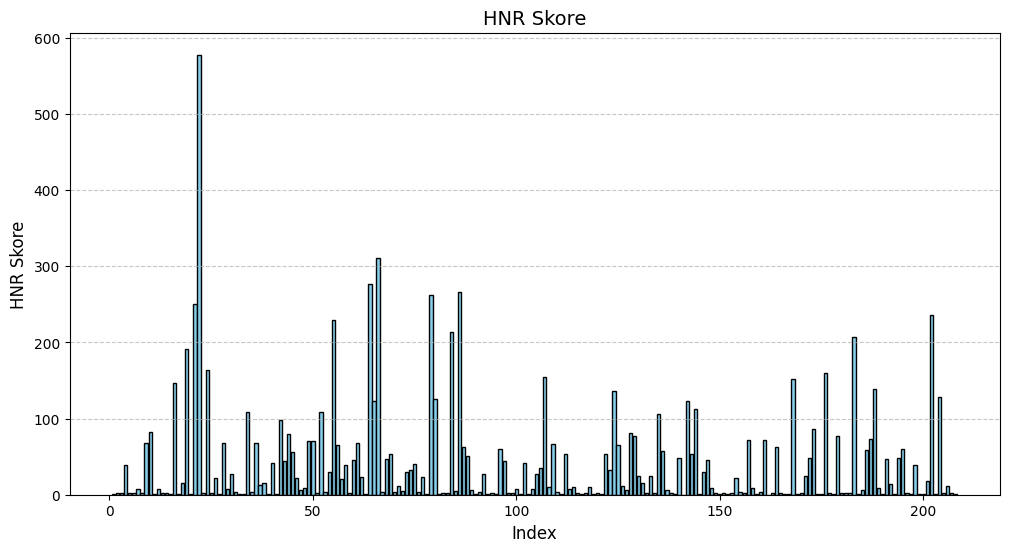

In [135]:
import numpy as np
import matplotlib.pyplot as plt

def compute_hnr(freqs, psd, harmonic_freqs):
    """
    Funkce pro výpočet Harmonic-to-Noise Ratio (HNR).
    """
    harmonic_band_power = 0  # Energie harmonických složek
    for f in harmonic_freqs:
        harmonic_band_power += np.sum(psd[(freqs > f - 50) & (freqs < f + 50)])
    
    # Energie šumu
    noise_band_power = np.sum(psd[(freqs < min(harmonic_freqs) - 50) | (freqs > max(harmonic_freqs) + 50)])
    
    if noise_band_power == 0:
        return 0
    
    return harmonic_band_power / noise_band_power

def compute_fourier_analysis(signal, sampling_rate=8000):
    """
    Funkce pro výpočet Fourierovy analýzy.
    """
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    psd = np.abs(fft_result) ** 2 / len(signal)
    positive_freqs = fft_freq[fft_freq >= 0]
    positive_psd = psd[fft_freq >= 0]
    return positive_freqs, positive_psd

def compute_hnr_for_all(audio_data, sampling_rate=8000):
    """
    Výpočet HNR pro všechny záznamy v datasetu.
    """
    hnr_scores = []

    for index, signal in enumerate(audio_data):
        # Fourierova analýza signálu
        freqs, psd = compute_fourier_analysis(signal, sampling_rate)

        # Výpočet fundamentální frekvence (nejvyšší hodnota PSD)
        fundamental_freq = freqs[np.argmax(psd)]

        # Výpočet harmonických frekvencí
        harmonic_freqs = [fundamental_freq * i for i in range(1, 10)]  # 9 harmonických

        # Výpočet HNR
        hnr = compute_hnr(freqs, psd, harmonic_freqs)
        hnr_scores.append(hnr)

        print(f"Signál {index + 1}: HNR = {hnr:.2f}")

    return hnr_scores

def plot_hnr_scores(hnr_scores):
    """
    Vizualizace HNR skóre pro všechny záznamy.
    """
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(hnr_scores) + 1), hnr_scores, color='skyblue', edgecolor='black')
    plt.title('HNR Skore', fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('HNR Skore', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

sampling_rate = 8000  # Frekvence vzorkování
hnr_scores = compute_hnr_for_all(audio_data, sampling_rate)
plot_hnr_scores(hnr_scores)


**STEP 10** KEPSTRÁLNÍ ANALÝZA

Signal 1: MFCC vypočteno.
Signal 2: MFCC vypočteno.
Signal 3: MFCC vypočteno.
Signal 4: MFCC vypočteno.
Signal 5: MFCC vypočteno.
Signal 6: MFCC vypočteno.
Signal 7: MFCC vypočteno.
Signal 8: MFCC vypočteno.
Signal 9: MFCC vypočteno.
Signal 10: MFCC vypočteno.
Signal 11: MFCC vypočteno.
Signal 12: MFCC vypočteno.
Signal 13: MFCC vypočteno.
Signal 14: MFCC vypočteno.
Signal 15: MFCC vypočteno.
Signal 16: MFCC vypočteno.
Signal 17: MFCC vypočteno.
Signal 18: MFCC vypočteno.
Signal 19: MFCC vypočteno.
Signal 20: MFCC vypočteno.
Signal 21: MFCC vypočteno.
Signal 22: MFCC vypočteno.
Signal 23: MFCC vypočteno.
Signal 24: MFCC vypočteno.
Signal 25: MFCC vypočteno.
Signal 26: MFCC vypočteno.
Signal 27: MFCC vypočteno.
Signal 28: MFCC vypočteno.
Signal 29: MFCC vypočteno.
Signal 30: MFCC vypočteno.
Signal 31: MFCC vypočteno.
Signal 32: MFCC vypočteno.
Signal 33: MFCC vypočteno.
Signal 34: MFCC vypočteno.
Signal 35: MFCC vypočteno.
Signal 36: MFCC vypočteno.
Signal 37: MFCC vypočteno.
Signal 38:

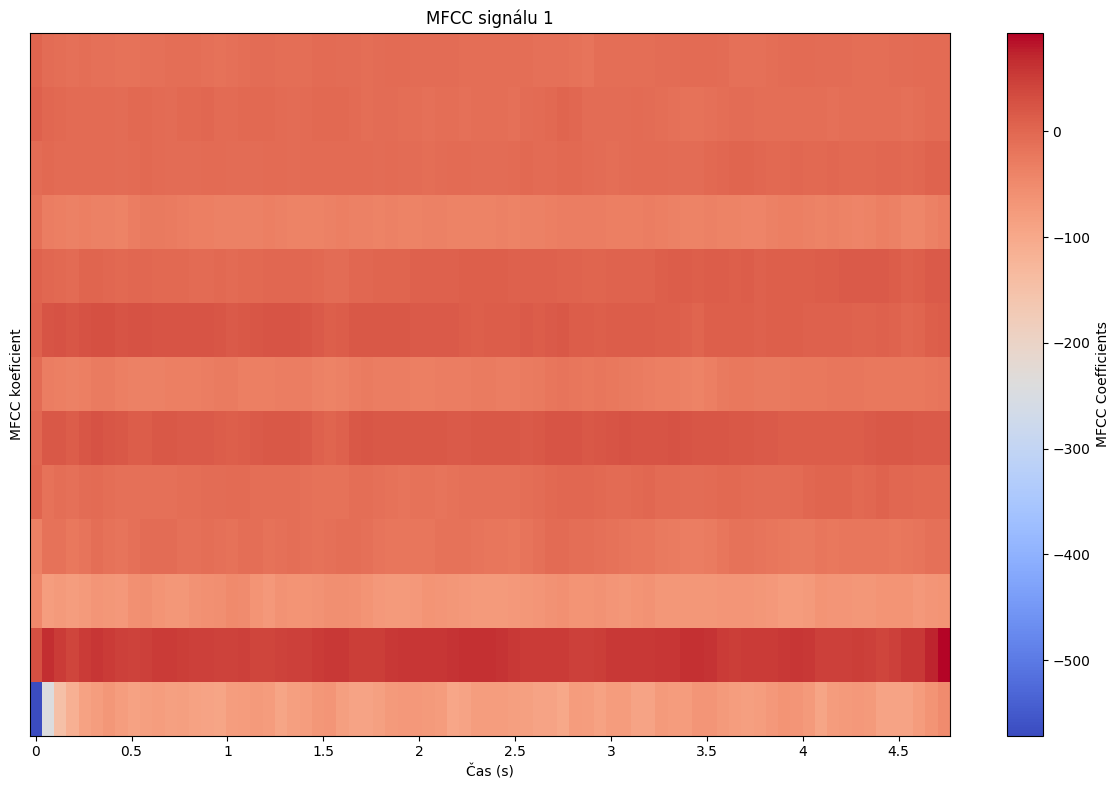

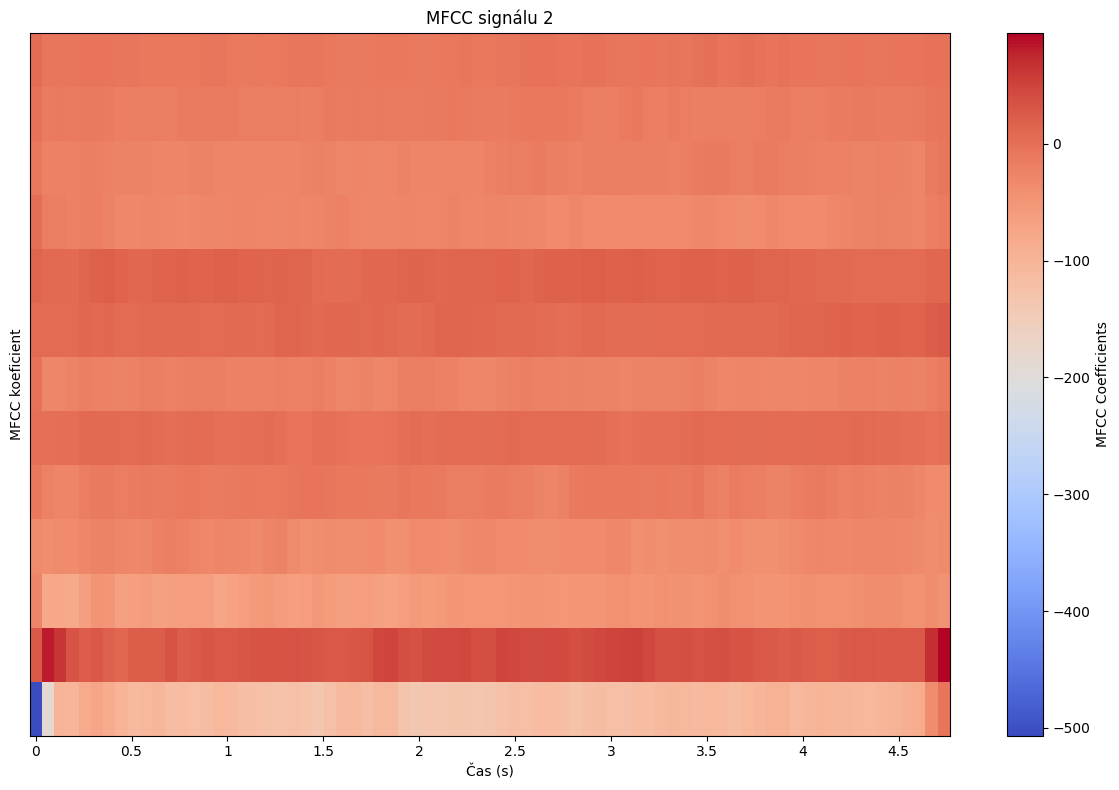

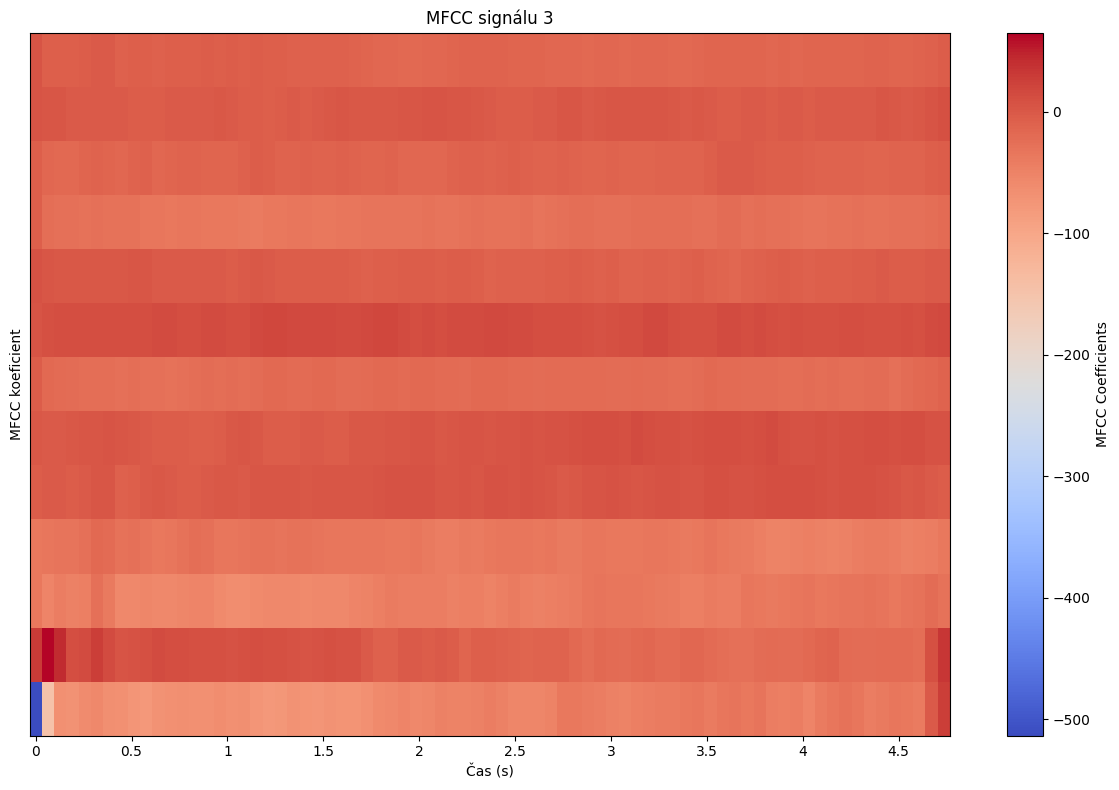

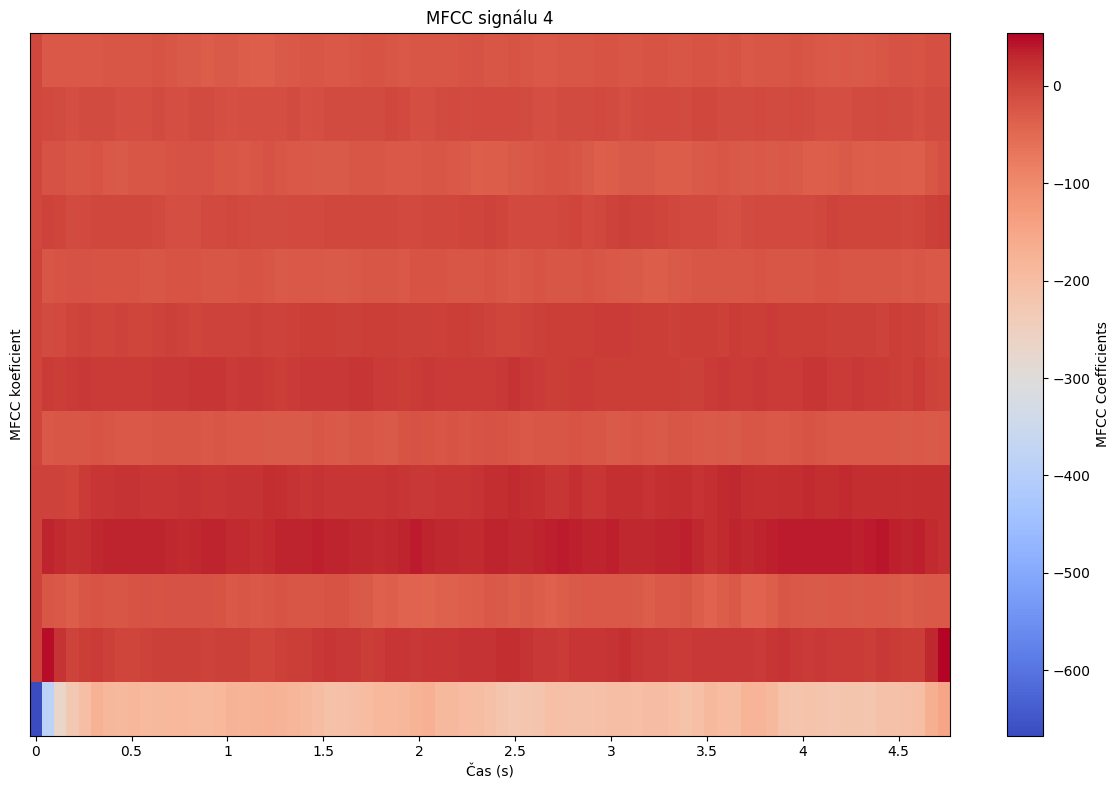

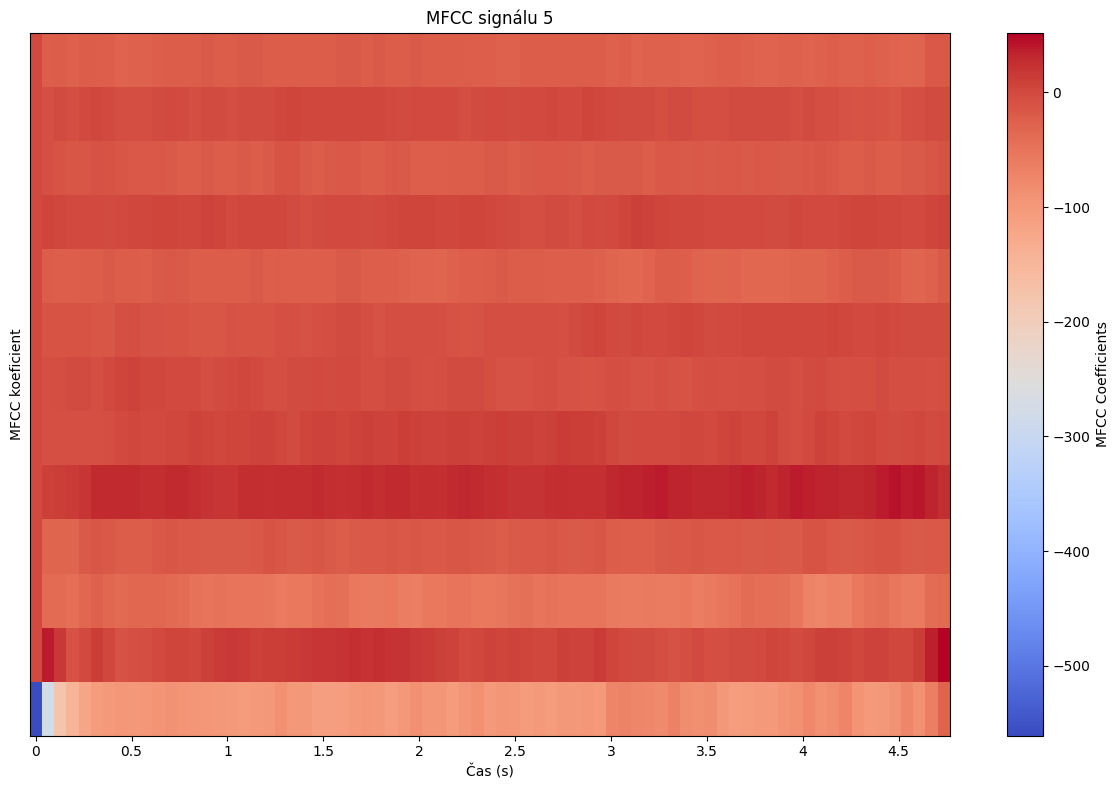

In [159]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import wfdb

def load_audio_data(directory):
    audio_data = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.dat'):
            
            record = wfdb.rdrecord(os.path.join(directory, filename[:-4]))
            audio_data.append(record.p_signal.flatten())
            
            
            label = load_label(os.path.join(directory, filename[:-4]))
            labels.append(label)
    
    return audio_data, labels

def load_label(base_filename):
    
    with open(base_filename + '.txt', 'r') as f:
        label = f.readline().strip()
    return label

def compute_mfcc(signal, sampling_rate=8000, n_mfcc=13):
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=n_mfcc)
    return mfcc

def visualize_mfcc(mfcc, signal_index, sampling_rate=8000):
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(mfcc, x_axis='time', sr=sampling_rate, cmap='coolwarm')
    plt.colorbar(label='MFCC Coefficients')
    plt.title(f'MFCC signálu {signal_index + 1}')
    plt.xlabel('Čas (s)')
    plt.ylabel('MFCC koeficient')
    plt.tight_layout()
    plt.show()

def compute_mfcc_for_all(audio_data, sampling_rate=8000, n_mfcc=13):
    mfcc_scores = []
    for index, signal in enumerate(audio_data):
        mfcc = compute_mfcc(signal, sampling_rate, n_mfcc)
        mfcc_scores.append(mfcc)
        print(f"Signal {index + 1}: MFCC vypočteno.")
    return mfcc_scores



audio_folder = 'database/'


audio_data, labels = load_audio_data(audio_folder)


mfcc_scores = compute_mfcc_for_all(audio_data)


for index in range(min(5, len(audio_data))):
    mfcc = mfcc_scores[index]
    visualize_mfcc(mfcc, index)




**STEP 11** SPOJENÍ HNR, MFCC, ZCR, SPECTRAL SKORE -> VÝSLEDEK

In [162]:
import os
import numpy as np
import librosa
import librosa.display
import wfdb

def load_audio_data(directory):
    audio_data = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.dat'):
            record = wfdb.rdrecord(os.path.join(directory, filename[:-4]))
            audio_data.append(record.p_signal.flatten())
            
            label = load_label(os.path.join(directory, filename[:-4]))
            labels.append(label)
    
    return audio_data, labels

def load_label(base_filename):
    with open(base_filename + '.txt', 'r') as f:
        label = f.readline().strip()
    return label

def compute_mfcc(signal, sampling_rate=8000, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=n_mfcc)
    return mfcc

def compute_hnr(signal, sampling_rate=8000):
    stft = librosa.stft(signal)
    magnitude = np.abs(stft)
    harmonic, noise = librosa.decompose.hpss(magnitude)
    harmonic_energy = np.sum(harmonic**2, axis=0)
    noise_energy = np.sum(noise**2, axis=0)
    hnr = 10 * np.log10(harmonic_energy / (noise_energy + 1e-10))
    return np.mean(hnr)

def compute_additional_features(signal, sampling_rate=8000):
    zcr = librosa.feature.zero_crossing_rate(signal)
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sampling_rate)
    return np.mean(zcr), np.mean(spectral_centroid)

def combine_features(hnr_scores, mfcc_scores, zcr_scores, spectral_centroid_scores):
    combined_features = []
    for hnr, mfcc, zcr, spectral_centroid in zip(hnr_scores, mfcc_scores, zcr_scores, spectral_centroid_scores):
        mfcc_mean = np.mean(mfcc, axis=1)
        combined = np.concatenate(([hnr], mfcc_mean, [zcr], [spectral_centroid]))
        combined_features.append(combined)
    return np.array(combined_features)

def classify_recordings(combined_features, hnr_threshold, mfcc_threshold, zcr_threshold, spectral_centroid_threshold):
    classifications = []
    for features in combined_features:
        hnr = features[0]
        mfcc_mean = np.mean(features[1:13])
        zcr = features[13]
        spectral_centroid = features[14]
        
        if (hnr < hnr_threshold or mfcc_mean < mfcc_threshold or 
            zcr > zcr_threshold or spectral_centroid > spectral_centroid_threshold):
            classifications.append('Pathological')
        else:
            classifications.append('Healthy')
    return classifications

audio_folder = 'database/'
audio_data, labels = load_audio_data(audio_folder)

mfcc_scores = [compute_mfcc(signal) for signal in audio_data]
hnr_scores = [compute_hnr(signal) for signal in audio_data]
zcr_scores = [compute_additional_features(signal)[0] for signal in audio_data]
spectral_centroid_scores = [compute_additional_features(signal)[1] for signal in audio_data]

combined_features = combine_features(hnr_scores, mfcc_scores, zcr_scores, spectral_centroid_scores)

hnr_threshold = 23  # Patogenní zvuk má obvykle nižší HNR než zdravý
mfcc_threshold = -65  # Patogenní zvuky mohou mít nižší amplitudy
zcr_threshold = 0.3  # Vyšší ZCR naznačuje patogenní zvuk
spectral_centroid_threshold = 1000  # Patogenní zvuky mohou mít nižší Spectral Centroid

classifications = classify_recordings(combined_features, hnr_threshold, mfcc_threshold, zcr_threshold, spectral_centroid_threshold)

pathological_count = classifications.count('Pathological')
healthy_count = classifications.count('Healthy')

confirmed_pathological = 150
confirmed_healthy = 58

pathological_accuracy = min((pathological_count / confirmed_pathological) * 100, 
                             100 - max(0, (pathological_count - confirmed_pathological) / confirmed_pathological * 100))
healthy_accuracy = min((healthy_count / confirmed_healthy) * 100, 
                       100 - max(0, (healthy_count - confirmed_healthy) / confirmed_healthy * 100))

print(f'\nVýsledky:')
print(f'Patogenních záznamů: {pathological_count} (POTVRZENÝCH: {confirmed_pathological})')
print(f'Zdravých záznamů: {healthy_count} (POTVRZENÝCH: {confirmed_healthy})')
print(f'Přesnost u patogenních záznamů: {pathological_accuracy:.2f}% (včetně true false)')
print(f'Přesnost u zdravých záznamů: {healthy_accuracy:.2f}% (včetně true false)')

C:\Users\kutsc\AppData\Local\Temp\ipykernel_18304\1962560513.py:36: RuntimeWarning: divide by zero encountered in log10
  hnr = 10 * np.log10(harmonic_energy / (noise_energy + 1e-10))



Výsledky:
Patogenních záznamů: 162 (POTVRZENÝCH: 150)
Zdravých záznamů: 46 (POTVRZENÝCH: 58)
Přesnost u patogenních záznamů: 92.00% (včetně true false)
Přesnost u zdravých záznamů: 79.31% (včetně true false)


Extrahovaná diagnóza pro soubor voice001.hea: hyperkinetic dysphonia
Extrahovaná diagnóza pro soubor voice002.hea: healthy
Extrahovaná diagnóza pro soubor voice003.hea: hyperkinetic dysphonia
Extrahovaná diagnóza pro soubor voice004.hea: hypokinetic dysphonia
Extrahovaná diagnóza pro soubor voice005.hea: hypokinetic dysphonia
Extrahovaná diagnóza pro soubor voice006.hea: hyperkinetic dysphonia
Extrahovaná diagnóza pro soubor voice007.hea: hyperkinetic dysphonia
Extrahovaná diagnóza pro soubor voice008.hea: reflux laryngitis
Extrahovaná diagnóza pro soubor voice009.hea: hyperkinetic dysphonia
Extrahovaná diagnóza pro soubor voice010.hea: hypokinetic dysphonia
Extrahovaná diagnóza pro soubor voice011.hea: reflux laryngitis
Extrahovaná diagnóza pro soubor voice012.hea: reflux laryngitis
Extrahovaná diagnóza pro soubor voice013.hea: reflux laryngitis
Extrahovaná diagnóza pro soubor voice014.hea: reflux laryngitis
Extrahovaná diagnóza pro soubor voice015.hea: reflux laryngitis
Extrahovaná d

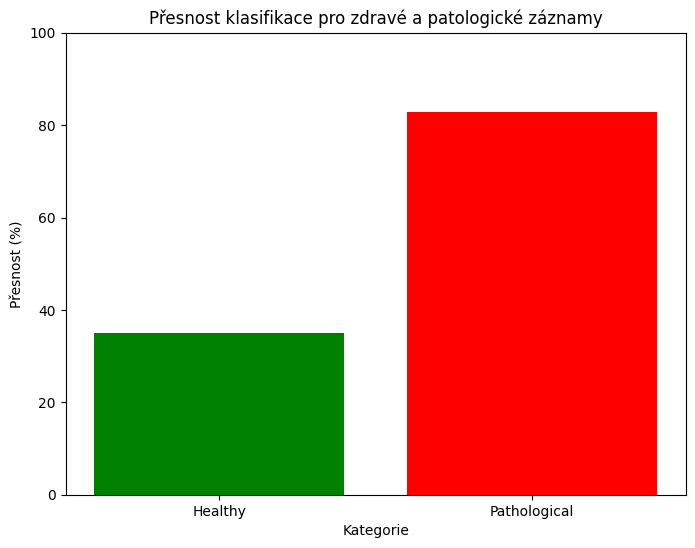

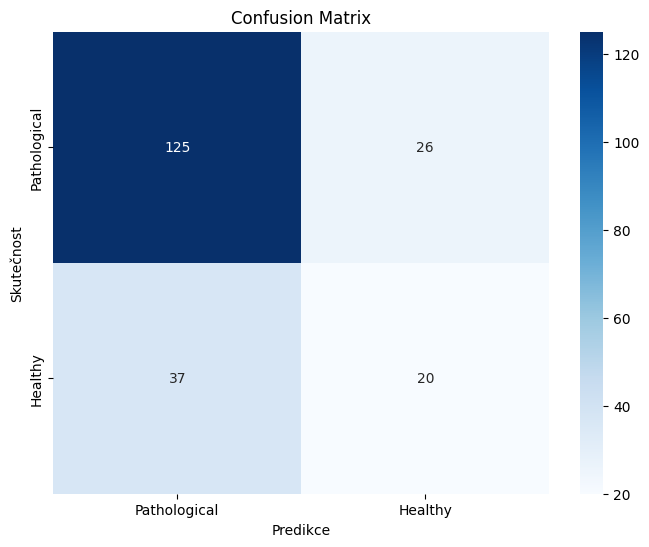

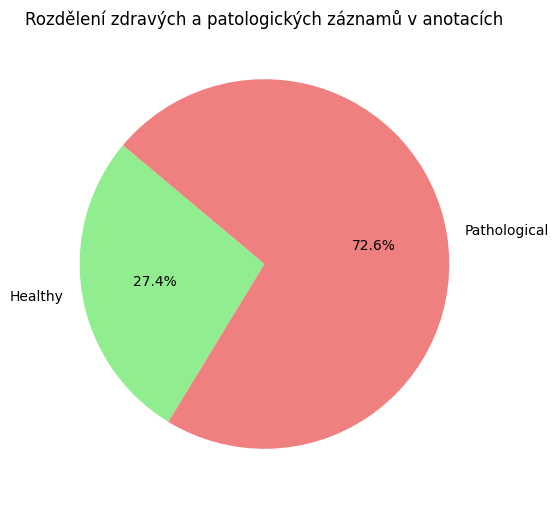

In [163]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


def load_annotations(directory):
    annotations = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.hea'):
            with open(os.path.join(directory, filename), 'r') as f:
                lines = f.readlines()
                
                diagnosis_line = [line for line in lines if '<diagnoses>' in line]
                if diagnosis_line:
                    
                    diagnosis = diagnosis_line[0].split('<diagnoses>: ')[1].strip()
                    
                    
                    if ' <' in diagnosis:
                        diagnosis = diagnosis.split(' <')[0]
                    
                    print(f"Extrahovaná diagnóza pro soubor {filename}: {diagnosis}")
                    
                    if diagnosis.lower() != 'healthy':
                        annotations.append('Pathological')
                    else:
                        annotations.append('Healthy')
                else:
                    annotations.append('Healthy')  
    return annotations


def compare_with_annotations(classifications, annotations):
    correct_count = 0
    results = []  
    for pred, true in zip(classifications, annotations):
        if pred.lower() == true.lower():
            correct_count += 1
            results.append((pred, true, "Shoda"))
        else:
            results.append((pred, true, "Neshoda"))
    return correct_count, results

audio_folder = 'database/'
annotations = load_annotations(audio_folder)

correct_count, results = compare_with_annotations(classifications, annotations)

# Class
print(f'Počet správně klasifikovaných záznamů: {correct_count} z {len(classifications)}')
print(f'Přesnost klasifikace: {(correct_count / len(classifications)) * 100:.2f}%')

# Shody
print("\nVýpis jednotlivých shod a neshod:")
for i, (pred, true, match_status) in enumerate(results[:208]):
    print(f'Příklad {i + 1}: Klasifikace: {pred}, Anotace: {true}, {match_status}')

# Vizualizace

# Bar chart
healthy_count = sum(1 for true in annotations if true.lower() == 'healthy')
pathological_count = sum(1 for true in annotations if true.lower() == 'pathological')

healthy_correct = sum(1 for pred, true in zip(classifications, annotations) if pred.lower() == true.lower() and true.lower() == 'healthy')
pathological_correct = sum(1 for pred, true in zip(classifications, annotations) if pred.lower() == true.lower() and true.lower() == 'pathological')

healthy_accuracy = (healthy_correct / healthy_count) * 100 if healthy_count > 0 else 0
pathological_accuracy = (pathological_correct / pathological_count) * 100 if pathological_count > 0 else 0

# Bar chart
categories = ['Healthy', 'Pathological']
accuracies = [healthy_accuracy, pathological_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=['green', 'red'])
plt.xlabel('Kategorie')
plt.ylabel('Přesnost (%)')
plt.title('Přesnost klasifikace pro zdravé a patologické záznamy')
plt.ylim(0, 100)
plt.show()

# Confusion Matrix
cm = confusion_matrix([1 if true.lower() == 'healthy' else 0 for true in annotations],
                      [1 if pred.lower() == 'healthy' else 0 for pred in classifications])

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pathological', 'Healthy'], yticklabels=['Pathological', 'Healthy'])
plt.xlabel('Predikce')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()

# 3. Pie chart
sizes = [healthy_count, pathological_count]
labels = ['Healthy', 'Pathological']
colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Rozdělení zdravých a patologických záznamů v anotacích')
plt.show()
